# relevant papers/posts
- [Toy Models of Superposition](https://transformer-circuits.pub/2022/toy_model/index.html)
- [Towards Monosemanticity: Decomposing Language Models With Dictionary Learning](https://transformer-circuits.pub/2023/monosemantic-features/index.html)
- [Sparse Autoencoders Find Highly Interpretable Features in Language Models](https://arxiv.org/abs/2309.08600)
- [Toward A Mathematical Framework for Computation in Superposition](https://www.lesswrong.com/posts/2roZtSr5TGmLjXMnT/toward-a-mathematical-framework-for-computation-in)
- [Neuronpedia](https://neuronpedia.org)

![](assets/feature-superposition.png)

![](assets/superposition-simulates.png)

![](assets/sae-explanation.png)

# setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import torch
from transformer_lens import HookedTransformer
from tqdm import tqdm
from transformer_lens.hook_points import HookPoint
from jaxtyping import Float, Int
from muutils.dictmagic import condense_tensor_dict

In [2]:
def print_tensor_dict(d: dict[str, torch.Tensor]) -> None:
	print(condense_tensor_dict(d, return_format="yaml"))

In [3]:
# load a subset of the tinystories dataset
with open("../data/tinystories_10k.txt", "r", encoding="utf-8") as f:
	TEXT_DATA: list[str] = f.read().split("<|endoftext|>")

In [4]:
MODEL: HookedTransformer = HookedTransformer.from_pretrained("tiny-stories-1M")

c:\Python\Python3_11\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loaded pretrained model tiny-stories-1M into HookedTransformer


In [5]:
MODEL.generate("Once upon a time", max_new_tokens=10)

  0%|          | 0/10 [00:00<?, ?it/s]

'Once upon a time, there was a big, little boy. He'

In [6]:
d_model: int = MODEL.cfg.d_model
n_layers: int = MODEL.cfg.n_layers
n_heads: int = MODEL.cfg.n_heads
d_vocab: int = MODEL.cfg.d_vocab

print(f"{d_model=}, {n_layers=}, {n_heads=}, {d_vocab=}")

d_model=64, n_layers=8, n_heads=16, d_vocab=50257


In [7]:
print_tensor_dict(MODEL.state_dict())

embed:
  W_E: (50257, 64)
pos_embed:
  W_pos: (2048, 64)
blocks:
  '[0-7]':
    attn:
      '[W_Q, W_K, W_V]': (16, 64, 4)
      W_O: (16, 4, 64)
      '[b_Q, b_K, b_V]': (16, 4)
      b_O: (64,)
      mask: (2048, 2048)
      IGNORE: ()
    mlp:
      W_in: (64, 256)
      b_in: (256,)
      W_out: (256, 64)
      b_out: (64,)
unembed:
  W_U: (64, 50257)
  b_U: (50257,)



# Looking at neurons directly

first, let's see that superposition is an actual problem in practice

In [8]:
logits, cache = MODEL.run_with_cache(TEXT_DATA[:3])

In [9]:
print(logits.shape)

torch.Size([3, 190, 50257])


In [10]:
print_tensor_dict(cache)

blocks:
  '[0-7]':
    ln1:
      hook_scale: (3, 190, 1)
      hook_normalized: (3, 190, 64)
    attn:
      '[hook_q, hook_k, hook_v, hook_z]': (3, 190, 16, 4)
      '[hook_attn_scores, hook_pattern]': (3, 16, 190, 190)
    ln2:
      hook_scale: (3, 190, 1)
      hook_normalized: (3, 190, 64)
    mlp:
      '[hook_pre, hook_post]': (3, 190, 256)
    '[hook_resid_pre, hook_attn_out, hook_resid_mid, hook_mlp_out, hook_resid_post]': (3,
      190, 64)
ln_final:
  hook_scale: (3, 190, 1)
  hook_normalized: (3, 190, 64)
'[hook_embed, hook_pos_embed]': (3, 190, 64)



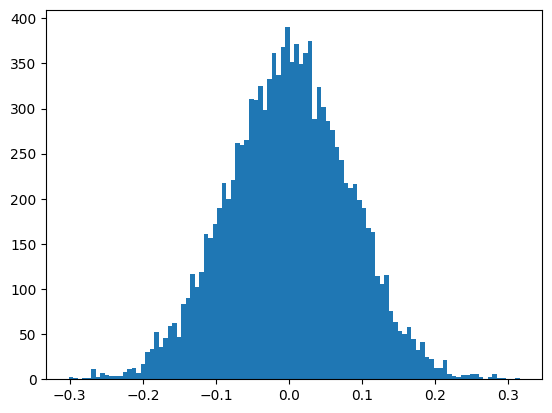

In [11]:
_ = plt.hist(cache["blocks.0.hook_resid_post"][0].flatten().cpu(), bins=100)

In [12]:
n_samples: int = 200

sample_activations: Float[torch.Tensor, "len(TEXT_DATA) d_model"] = torch.zeros(n_samples, d_model)

print(f"{d_model = }")

for idx, text in enumerate(TEXT_DATA[:n_samples]):
	logits, cache = MODEL.run_with_cache([text])
	sample_activations[idx] = cache["blocks.0.hook_resid_post"][0].mean(dim=0)

d_model = 64


In [13]:
print(sample_activations.shape)

chosen_dimension_sample_activations = sample_activations[:, 5]
top_k = torch.topk(chosen_dimension_sample_activations, k=2)
bottom_k = torch.topk(chosen_dimension_sample_activations, k=2, largest=False)
print(top_k)

for idx in top_k.indices:
	print(TEXT_DATA[idx])
	print('-'*20)

for idx in bottom_k.indices:
	print(TEXT_DATA[idx])
	print('-'*20)

# plt.hist(chosen_dimension_sample_activations.cpu(), bins=50)

torch.Size([200, 64])
torch.return_types.topk(
values=tensor([0.0115, 0.0020]),
indices=tensor([118,  63]))

Once upon a time, there was an old dog named Spot. Spot had an itch on his back that he could not scratch. He tried and tried, but his legs were too short to reach the itch.
One sunny day, Spot met a friendly cat named Fluffy. Fluffy saw Spot trying to scratch his itch and felt bad for him. Fluffy had an idea. "I can help you with your itch, Spot," said Fluffy. "Let's share our paws and help each other." Spot agreed, and they became friends.
Fluffy used her paw to scratch Spot's itch, and he felt so much better. In return, Spot shared his favorite toy with Fluffy, and they played together all day. From that day on, Spot and Fluffy always shared their toys and helped each other when they had itches. And they lived happily ever after.

--------------------

Once upon a time, there was a clumsy dog named Spot. Spot loved to play and run around. One day, Spot and his family went to 

## finding neurons that activate on a certain feature

first, we need to come up with a feature and come up with some positive and negative examples

In [14]:
# TODO

# SAEs

## set up the sparse autoencoder

In [15]:
class SAE(torch.nn.Module):
	def __init__(self, d_model: int, d_hidden: int):
		super(SAE, self).__init__()
		self.encoder: torch.nn.Module = torch.nn.Sequential(
			torch.nn.Linear(d_model, d_hidden, bias=True),
			torch.nn.ReLU(),
		)
		self.decoder: torch.nn.Module = torch.nn.Sequential(
			torch.nn.Linear(d_hidden, d_model, bias=True),
		)

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.decoder(self.encoder(x))

## set up the training loop

In [18]:
def train_sae(
	model: HookedTransformer,
	dataset: list[str] = TEXT_DATA[:256],
	batchsize: int = 16,
	epochs: int = 10,
	sae_hidden: int = 128,
	learning_rate: float = 1e-3,
	block_id: int = 0,
	sparsity_coeff: float = 1e-3,
	device: torch.device|str = "cuda" if torch.cuda.is_available() else "cpu",
):
	# dont keep gradients for the model
	model.eval()
	d_model: int = model.cfg.d_model
	n_samples: int = len(dataset)

	sae: SAE = SAE(d_model, sae_hidden)
	sae.to(device)
	optimizer: torch.optim.Adam = torch.optim.Adam(sae.parameters(), lr=learning_rate)
	reconstruction_loss: torch.nn.Module = torch.nn.MSELoss()
	sparsity_penalty: torch.nn.Module = torch.nn.L1Loss()
	sparsity_target: torch.Tensor = torch.zeros(batchsize, sae_hidden).to(device)

	hook_id: str = f"blocks.{block_id}.hook_resid_post"
	hook_cache: torch.Tensor = torch.zeros(batchsize, d_model).to(device)

	def hook_fn(x: torch.Tensor, hook: HookPoint):
		hook_cache = x
		return None # we don't modify the activation

	for epoch in range(epochs):
		epoch_loss: float = 0.0
		idx: int = 0
		for batch_idx in tqdm(range(0, n_samples // batchsize)):
			if idx + batchsize > n_samples:
				break
			batch = dataset[idx:idx+batchsize]
			idx += len(batch)
			model.run_with_hooks(
				batch,
				fwd_hooks=[(
					hook_id,
					hook_fn,
				)],
				return_type=None, # for efficiency
			)
			activations: Float[torch.Tensor, "batchsize d_model"] = hook_cache
			# print(f"{activations.shape=}")
			activations = activations.detach().to(device)
			optimizer.zero_grad()
			hidden_activations: Float[torch.Tensor, "len(batch) sae_hidden"] = sae.encoder(activations)
			reconstructed_activations: Float[torch.Tensor, "len(batch) d_model"] = sae.decoder(hidden_activations)
			loss = reconstruction_loss(reconstructed_activations, activations) + sparsity_coeff * sparsity_penalty(hidden_activations, sparsity_target)
			loss.backward()
			optimizer.step()
			epoch_loss += loss.item()
			del activations
			del hidden_activations
			del reconstructed_activations
			del loss
		print(f"Epoch {epoch}: {epoch_loss}")

	return sae


TRAINED_SAE = train_sae(MODEL, epochs=5, sae_hidden=128, sparsity_coeff=1e-3)

100%|██████████| 16/16 [00:04<00:00,  3.67it/s]


Epoch 0: 0.016180742837605067


100%|██████████| 16/16 [00:04<00:00,  3.93it/s]


Epoch 1: 0.0015572813135804608


100%|██████████| 16/16 [00:04<00:00,  3.92it/s]


Epoch 2: 0.0007762109671602957


100%|██████████| 16/16 [00:04<00:00,  3.93it/s]


Epoch 3: 0.0005092821174912388


100%|██████████| 16/16 [00:04<00:00,  3.93it/s]

Epoch 4: 0.00047132808322203346


## find features which correspond to a sample of text